# How to Build a Simple Video Summarizer App Using Aana SDK

In this notebook, we will demonstrate how to build the backend for an app that takes a video from YouTube, downloads it, and runs audio, video, and language models on it to generate a relevant summary. Additionally, you will be able to ask questions about the video from all modalities present, similar to the example shown below.

![Aana Demo](https://mobiusml.github.io/aana-sdk-introducing-blog/figs/aana_intro.gif)

The API will be accessible at `http://127.0.0.1:8005/video/chat_stream` and will stream out JSON objects.

## Installation

Aana is available on PyPI, so you can simply install it using pip. Alternatively, you can compile it using Poetry and easily containerize it. See more details at [Aana SDK GitHub](https://github.com/mobiusml/aana_sdk).

In [1]:
!pip install git+https://github.com/mobiusml/aana_sdk.git -qqqU

## Basic Building Blocks of Aana SDK

AanaSDK is the main class we will use to build our application. There are three main components in Aana SDK:

- **Deployments**: These are typically large machine learning models or heavy functions required for the application. They allow different parts of the application logic to call them without having to load them multiple times. Further, they can be deployed on a single machine or scaled across a cluster.
- **Endpoints**: This is where the application logic and functionality reside. Endpoints allow us to connect multiple deployments (models) to each other and define the input and output of the applications.
- **Main Class of Aana SDK**: This class allows us to deploy the deployments into clusters and endpoints, and to start and manage the application.

Note: AanaSDK is built on top of Ray and RayServe, which provides flexibility in scaling.

In [2]:
from aana.sdk import AanaSDK
aana_app = AanaSDK(name="chat_with_video_app")

/root/.cache/pypoetry/virtualenvs/aana-XDlPP_xZ-py3.10/lib/python3.10/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_dir" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ('settings_',)`.
  warnings.warn(


## Deployments
Deployments are the building blocks of Aana SDK. They represent the machine learning models that you want to deploy. Aana SDK comes with a set of predefined deployments that you can use or you can define your own deployments. For this demo, we will use a set of predefined deployments. 

Each deployment has a main class that defines it and a configuration class that allows you to specify the deployment parameters.

For this application, we will be using:
* Blip2 for extracting computer vision captions (https://huggingface.co/docs/transformers/main/en/model_doc/blip-2)
* Whisper for audio recognition (https://github.com/mobiusml/faster-whisper)
* InternLM for LLM, which is currently at the top of the LLM leaderboard for the 7B class of models (https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard)

Note, you will require a GPU(s) with 40GB of VRAM. We will use A6000s and is circa 0.60$ per hour in services like runpod and vast.ai 

In [3]:
from aana.configs.deployments import (
    hf_blip2_opt_2_7b_deployment,
    internlm2_5_7b_chat_deployment,
    whisper_medium_deployment,
)

/root/.cache/pypoetry/virtualenvs/aana-XDlPP_xZ-py3.10/lib/python3.10/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/aana-XDlPP_xZ-py3.10/lib/python3.10/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_kwargs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/aana-XDlPP_xZ-py3.10/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
deployments = [
    {
        "name": "asr_deployment",
        "instance": whisper_medium_deployment,
    },    
    {
        "name": "captioning_deployment",
        "instance": hf_blip2_opt_2_7b_deployment,
    },
    {
        "name": "llm_deployment",
        "instance": internlm2_5_7b_chat_deployment,
    },
]

for deployment in deployments:
    aana_app.register_deployment(
        name=deployment["name"],
        instance=deployment["instance"],
    )

In [5]:
from aana.integrations.external.yt_dlp import download_video
from aana.processors.video import extract_audio

## Application Logic

Endpoints define the functionality of your application. They allow you to connect multiple deployments (models) to each other and define the input and output of your application.

Each endpoint is defined as a class that inherits from the `Endpoint` class. The class has two main methods: `initialize` and `run`.

In this example, we will create two endpoints:
1. `IndexVideoEndpoint`: To get the output of computer vision models and automatic transcript models. The output will be stored in an object of the `IndexVideoOutput` class.
2. `VideoChatEndpoint`: Where you can ask questions about an indexed video.

### Other Nice Things 
1. Aana comes pre-built with some goodies (functions) to extract frames, audio, etc. It also comes with a set of predefined types for various data such as images, videos, etc., making it simpler to handle multimodal data and further processing on it.
2. Aana supports streaming, and the output of the endpoint will be streamed to the client as it is generated.

In [6]:
import json
from collections.abc import AsyncGenerator
from typing import TYPE_CHECKING, Annotated, TypedDict

from pydantic import Field

from aana.api.api_generation import Endpoint
from aana.core.models.asr import (
    AsrSegments,
    AsrTranscription,
    AsrTranscriptionInfo,
)
from aana.core.models.chat import Question
from aana.core.models.media import MediaId
from aana.core.models.sampling import SamplingParams
from aana.core.models.video import VideoInput, VideoMetadata, VideoParams
from aana.core.models.whisper import BatchedWhisperParams
from aana.deployments.aana_deployment_handle import AanaDeploymentHandle
from aana.exceptions.db import MediaIdAlreadyExistsException, UnfinishedVideoException
from aana.exceptions.io import VideoTooLongException
from aana.integrations.external.decord import generate_frames, get_video_duration
from aana.processors.remote import run_remote
from aana.processors.video import generate_combined_timeline
from aana.projects.chat_with_video.const import (
    asr_model_name,
    captioning_model_name,
    max_video_len,
)
from aana.projects.chat_with_video.utils import (
    generate_dialog,
)
from aana.storage.models.video import Status
from aana.storage.services.video import (
    check_media_id_exist,
    get_video_status,
    load_video_captions,
    load_video_metadata,
    load_video_transcription,
    save_video,
    save_video_captions,
    save_video_transcription,
    update_video_status,
)

if TYPE_CHECKING:
    from aana.core.models.audio import Audio
    from aana.core.models.video import Video


class IndexVideoOutput(TypedDict):
    """The output of the transcribe video endpoint."""

    media_id: MediaId
    metadata: VideoMetadata
    transcription: AsrTranscription
    transcription_info: AsrTranscriptionInfo
    segments: AsrSegments

    captions: Annotated[list[str], Field(..., description="Captions")]
    timestamps: Annotated[
        list[float], Field(..., description="Timestamps for each caption in seconds")
    ]

    transcription_id: Annotated[int, Field(..., description="Transcription Id")]
    caption_ids: Annotated[list[int], Field(..., description="Caption Ids")]

class IndexVideoEndpoint(Endpoint):
    """Transcribe video in chunks endpoint."""

    async def initialize(self):
        """Initialize the endpoint."""
        self.asr_handle = await AanaDeploymentHandle.create("asr_deployment")
        self.captioning_handle = await AanaDeploymentHandle.create(
            "captioning_deployment"
        )
        await super().initialize()

    async def run(
        self,
        video: VideoInput,
        video_params: VideoParams,
        whisper_params: BatchedWhisperParams,       
    ) -> AsyncGenerator[IndexVideoOutput, None]:
        """Transcribe video in chunks."""
        media_id = video.media_id
        if check_media_id_exist(media_id):
            raise MediaIdAlreadyExistsException(table_name="media", media_id=video)

        video_obj: Video = await run_remote(download_video)(video_input=video)
        video_duration = await run_remote(get_video_duration)(video=video_obj)

        if video_duration > max_video_len:
            raise VideoTooLongException(
                video=video_obj,
                video_len=video_duration,
                max_len=max_video_len,
            )

        save_video(video=video_obj, duration=video_duration)
        yield {
            "media_id": media_id,
            "metadata": VideoMetadata(
                title=video_obj.title, description=video_obj.description
            ),
        }

        try:
            update_video_status(media_id=media_id, status=Status.RUNNING)
            audio: Audio = extract_audio(video=video_obj)


            transcription_list = []
            segments_list = []
            transcription_info_list = []
            async for whisper_output in self.asr_handle.transcribe_stream(
                audio=audio, params=whisper_params
            ):
                transcription_list.append(whisper_output["transcription"])
                segments_list.append(whisper_output["segments"])
                transcription_info_list.append(whisper_output["transcription_info"])
                yield {
                    "transcription": whisper_output["transcription"],
                    "segments": whisper_output["segments"],
                    "info": whisper_output["transcription_info"],
                }
            transcription = sum(transcription_list, AsrTranscription())
            segments = sum(segments_list, AsrSegments())
            transcription_info = sum(transcription_info_list, AsrTranscriptionInfo())

            captions = []
            timestamps = []
            frame_ids = []

            async for frames_dict in run_remote(generate_frames)(
                video=video_obj, params=video_params
            ):
                if len(frames_dict["frames"]) == 0:
                    break

                timestamps.extend(frames_dict["timestamps"])
                frame_ids.extend(frames_dict["frame_ids"])

                captioning_output = await self.captioning_handle.generate_batch(
                    images=frames_dict["frames"]
                )
                captions.extend(captioning_output["captions"])

                yield {
                    "captions": captioning_output["captions"],
                    "timestamps": frames_dict["timestamps"],
                }

            save_video_transcription_output = save_video_transcription(
                model_name=asr_model_name,
                media_id=video_obj.media_id,
                transcription=transcription,
                segments=segments,
                transcription_info=transcription_info,
            )

            save_video_captions_output = save_video_captions(
                model_name=captioning_model_name,
                media_id=video_obj.media_id,
                captions=captions,
                timestamps=timestamps,
                frame_ids=frame_ids,
            )

            yield {
                "transcription_id": save_video_transcription_output["transcription_id"],
                "caption_ids": save_video_captions_output["caption_ids"],
            }
        except BaseException:
            update_video_status(media_id=media_id, status=Status.FAILED)
            raise
        else:
            update_video_status(media_id=media_id, status=Status.COMPLETED)

class VideoChatEndpointOutput(TypedDict):
    """Video chat endpoint output."""
    completion: Annotated[str, Field(description="Generated text.")]


class VideoChatEndpoint(Endpoint):
    """Video chat endpoint."""

    async def initialize(self):
        """Initialize the endpoint."""
        self.llm_handle = await AanaDeploymentHandle.create("llm_deployment")
        await super().initialize()

    async def run(
        self, media_id: MediaId, question: Question, sampling_params: SamplingParams
    ) -> AsyncGenerator[VideoChatEndpointOutput, None]:
        """Run the video chat endpoint."""
        # check to see if video already processed
        video_status = get_video_status(media_id=media_id)
        if video_status != Status.COMPLETED:
            raise UnfinishedVideoException(
                media_id=media_id,
                status=video_status,
                message=f"The video data is not available, status: {video_status}",
            )

        load_video_transcription_output = load_video_transcription(
            media_id=media_id, model_name=asr_model_name
        )

        loaded_video_captions_output = load_video_captions(
            media_id=media_id, model_name=captioning_model_name
        )

        video_metadata = load_video_metadata(media_id=media_id)

        timeline_output = generate_combined_timeline(
            transcription_segments=load_video_transcription_output["segments"],
            captions=loaded_video_captions_output["captions"],
            caption_timestamps=loaded_video_captions_output["timestamps"],
        )
        timeline_json = json.dumps(
            timeline_output["timeline"], indent=4, separators=(",", ": ")
        )

        dialog = generate_dialog(
            metadata=video_metadata,
            timeline=timeline_json,
            question=question,
        )
        async for item in self.llm_handle.chat_stream(
            dialog=dialog, sampling_params=sampling_params
        ):
            yield {"completion": item["text"]}


In [7]:
endpoints = [
    {
        "name": "index_video_stream",
        "path": "/video/index_stream",
        "summary": "Index a video and return the captions and transcriptions as a stream",
        "endpoint_cls": IndexVideoEndpoint,
    },
    {
        "name": "video_chat_stream",
        "path": "/video/chat_stream",
        "summary": "Chat with video using LLaMa2 7B Chat (streaming)",
        "endpoint_cls": VideoChatEndpoint,
    },   
]

for endpoint in endpoints:
    aana_app.register_endpoint(
        name=endpoint["name"],
        path=endpoint["path"],
        summary=endpoint["summary"],
        endpoint_cls=endpoint["endpoint_cls"],
    )

## Let us spin-up the application! 
Another nice thing: Aana will automatically generate the documentation for the applicaiton based on our defined end points. 

In [8]:
aana_app.connect(host="127.0.0.1", port=8005, show_logs=False)  # Connects to the Ray cluster or starts a new one.
aana_app.migrate()                                              # Runs the migrations to create the database tables.
aana_app.deploy(blocking=False)

(ProxyActor pid=668003) INFO 2024-07-10 15:39:03,317 proxy 172.17.0.5 proxy.py:1179 - Proxy starting on node c7b6eed15c44eb2d4049126a830c6ed34dba65f98c462fe441cec0e9 (HTTP port: 8005).
(ServeController pid=667917) INFO 2024-07-10 15:39:03,439 controller 667917 deployment_state.py:1598 - Deploying new version of Deployment(name='TaskQueueDeployment', app='task_queue_deployment') (initial target replicas: 1).
(ServeController pid=667917) INFO 2024-07-10 15:39:03,544 controller 667917 deployment_state.py:1844 - Adding 1 replica to Deployment(name='TaskQueueDeployment', app='task_queue_deployment').
(ServeReplica:task_queue_deployment:TaskQueueDeployment pid=668078) /root/.cache/pypoetry/virtualenvs/aana-XDlPP_xZ-py3.10/lib/python3.10/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_dir" has conflict with protected namespace "model_".
(ServeReplica:task_queue_deployment:TaskQueueDeployment pid=668078) 
(ServeReplica:task_queue_deployment:TaskQueueDeployment pid=66

(ServeReplica:llm_deployment:VLLMDeployment pid=668719) INFO 07-10 15:39:29 llm_engine.py:169] Initializing an LLM engine (v0.5.1) with config: model='internlm/internlm2_5-7b-chat', speculative_config=None, tokenizer='internlm/internlm2_5-7b-chat', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=50000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=True, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=internlm/internlm2_5-7b-chat, use_v2_block_manager=False, enable_prefix_caching=False)
(ServeReplica:llm_deployment:VLLMDeployment pid=668719) INFO 07-10 15:3

(ServeController pid=667917) INFO 2024-07-10 15:39:46,822 controller 667917 deployment_state.py:1598 - Deploying new version of Deployment(name='RequestHandler', app='chat_with_video_app') (initial target replicas: 2).
(ServeController pid=667917) INFO 2024-07-10 15:39:46,927 controller 667917 deployment_state.py:1844 - Adding 2 replicas to Deployment(name='RequestHandler', app='chat_with_video_app').
(ServeReplica:chat_with_video_app:RequestHandler pid=668852) /root/.cache/pypoetry/virtualenvs/aana-XDlPP_xZ-py3.10/lib/python3.10/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_dir" has conflict with protected namespace "model_".
(ServeReplica:chat_with_video_app:RequestHandler pid=668852) 
(ServeReplica:chat_with_video_app:RequestHandler pid=668852) You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ('settings_',)`.
(ServeReplica:chat_with_video_app:RequestHandler pid=668852)   warnings.warn(
(ServeReplica:chat_with_vid

Deployed successfully.

Documentation is available at ]8;id=156309;http://127.0.0.1:8005/docs\http://127.0.0.1:8005/docs]8;;\ and ]8;id=393012;http://127.0.0.1:8005/redoc\http://127.0.0.1:8005/redoc]8;;\

## Viola! 

In [9]:
import json
import re
import requests
from datetime import datetime
url = "https://www.youtube.com/watch?v=GBVkDfXUSls&ab_channel=KeralaTourism"

match = re.search(r"v=([^&]+)", url)
video_id = match.group(1) if match else None
media_id = f"{video_id}_{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

video = {
    "url": url,  # Video URL, Aana SDK supports URLs (including YouTube), file paths or even raw video data
    "media_id": media_id,  # Media ID, so we can ask questions about the video later by using this ID
}

data = {
    "video_params": {
        "fast_mode_enabled": True,  # Enable fast mode, which only processes keyframes
    },
    "video": video,
}

url = "http://127.0.0.1:8005/video/index_stream"
response = requests.post(url, data={"body": json.dumps(data)}, stream=True)

for chunk in response.iter_content(chunk_size=None):
    json_data = json.loads(chunk)
    if "error" in json_data:
        print(json_data["error"])
        print(json_data["message"])
        print(json_data["stacktrace"])
        break
    else:
        print(json_data)

(ServeReplica:asr_deployment:WhisperDeployment pid=668429) INFO 2024-07-10 15:39:50,941 asr_deployment_WhisperDeployment cfarpaq5 811207da-780c-44a6-aeb8-dd27132bc811 /video/index_stream replica.py:373 - GET_METHODS OK 4.0ms
(ServeReplica:chat_with_video_app:RequestHandler pid=668853) /root/.cache/pypoetry/virtualenvs/aana-XDlPP_xZ-py3.10/lib/python3.10/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_size" has conflict with protected namespace "model_".
(ServeReplica:chat_with_video_app:RequestHandler pid=668853) 
(ServeReplica:chat_with_video_app:RequestHandler pid=668853) You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
(ServeReplica:chat_with_video_app:RequestHandler pid=668853)   warnings.warn(
(ServeReplica:captioning_deployment:HFBlip2Deployment pid=668528) INFO 2024-07-10 15:39:50,994 captioning_deployment_HFBlip2Deployment xpu7gxgq 811207da-780c-44a6-aeb8-dd27132bc811 /video/index_stream replica.py:373 - 

(download_video pid=669041) [youtube] Extracting URL: https://www.youtube.com/watch?v=GBVkDfXUSls&ab_channel=KeralaTourism
(download_video pid=669041) [youtube] GBVkDfXUSls: Downloading webpage
(download_video pid=669041) [youtube] GBVkDfXUSls: Downloading ios player API JSON


{'media_id': 'GBVkDfXUSls_2024-07-10 15:39:50', 'metadata': {'title': "Appu's Big Friend | Kerala Tourism", 'description': 'It’s just another day for Appu and his big friend. But it’s an escape from the ordinary for you!'}}
{'transcription': {'text': ' The next day'}, 'segments': [{'text': ' The next day', 'time_interval': {'start': 0.0, 'end': 2.0}, 'confidence': 0.41127130245336685, 'no_speech_confidence': 0.142822265625, 'words': []}], 'info': {'language': 'jw', 'language_confidence': 0.3759765625}}
{'transcription': {'text': ' Hey come on!'}, 'segments': [{'text': ' Hey come on!', 'time_interval': {'start': 9.0, 'end': 10.0}, 'confidence': 0.41127130245336685, 'no_speech_confidence': 0.142822265625, 'words': []}], 'info': {'language': 'jw', 'language_confidence': 0.3759765625}}
{'transcription': {'text': ' Where are you going?'}, 'segments': [{'text': ' Where are you going?', 'time_interval': {'start': 16.0, 'end': 17.0}, 'confidence': 0.41127130245336685, 'no_speech_confidence': 0

(ServeReplica:asr_deployment:WhisperDeployment pid=668429) INFO 2024-07-10 15:40:20,652 asr_deployment_WhisperDeployment cfarpaq5 811207da-780c-44a6-aeb8-dd27132bc811 /video/index_stream replica.py:373 - TRANSCRIBE_STREAM OK 23209.2ms
(pid=669041)   warnings.warn(
(ServeReplica:captioning_deployment:HFBlip2Deployment pid=668528) Both `max_new_tokens` (=64) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
(ServeReplica:captioning_deployment:HFBlip2Deployment pid=668528) Both `max_new_tokens` (=64) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
(ServeReplica:captioning_deployment:HFBlip2Deployment pid=668528) Both `max_new_tokens` (=64) and `max_leng

In [10]:

question = (
    "What is happening in this video? "
    "Focus on highlighting the story, the narrative, emotionally and thematically significant aspects. "
    "Do not use bulleted list in your answer."
)

data = {
    "question": question,
    "media_id": media_id,
    "sampling_params": {
        "temperature": 0.9,
        "max_tokens": 1024,
    },
}

url = "http://127.0.0.1:8005/video/chat_stream"

response = requests.post(url, data={"body": json.dumps(data)}, stream=True)
op = ""
for chunk in response.iter_content(chunk_size=None):
    chunk_dict = json.loads(chunk)
    
    if "error" in chunk_dict:
        print(chunk_dict["error"])
        print(chunk_dict["message"])
        print(chunk_dict["stacktrace"])
        break
    token = chunk_dict["completion"]
    op += token
    print(token, end="")

(ServeReplica:llm_deployment:VLLMDeployment pid=668719) INFO 07-10 15:40:37 async_llm_engine.py:646] Received request 4c930b002af3447e9d4b208ed0dcba1a: prompt: None, params: SamplingParams(n=1, best_of=1, presence_penalty=0.0, frequency_penalty=0.0, repetition_penalty=1.0, temperature=0.9, top_p=1.0, top_k=-1, min_p=0.0, seed=None, use_beam_search=False, length_penalty=1.0, early_stopping=False, stop=[], stop_token_ids=[], include_stop_str_in_output=False, ignore_eos=False, max_tokens=1024, min_tokens=0, logprobs=None, prompt_logprobs=None, skip_special_tokens=True, spaces_between_special_tokens=True, truncate_prompt_tokens=None), prompt_token_ids: [1, 1, 92543, 9081, 364, 2770, 657, 395, 11100, 328, 47407, 328, 454, 10894, 17993, 281, 23572, 4384, 569, 1638, 3802, 569, 3369, 328, 1539, 22865, 7299, 281, 1592, 818, 517, 4054, 579, 395, 5475, 435, 3116, 3722, 500, 395, 2930, 8617, 2145, 635, 9253, 6584, 1045, 454, 7839, 58989, 281, 9020, 4503, 435, 410, 5475, 11170, 410, 3722, 1593, 388

(ServeReplica:captioning_deployment:HFBlip2Deployment pid=668528) INFO 2024-07-10 15:40:37,368 captioning_deployment_HFBlip2Deployment xpu7gxgq 811207da-780c-44a6-aeb8-dd27132bc811 /video/index_stream replica.py:373 - GENERATE_BATCH OK 354.4ms
(ServeReplica:chat_with_video_app:RequestHandler pid=668853) INFO 2024-07-10 15:40:37,416 chat_with_video_app_RequestHandler paukoh41 811207da-780c-44a6-aeb8-dd27132bc811 /video/index_stream replica.py:373 - __CALL__ OK 46527.8ms


The video titled "Appu's Big Friend | Kerala Tourism" explores the idyllic and culturally rich environment of Kerala, India. It tells the story of young Appu and his adventures with Ganesha, who is accompanied by an elephant. Ganesha plays a central role in the lives of both Appu and his community, embodying themes of freedom, adventure, and friendship.

The narrative begins with a serene countryside setting, where Ganesha and Appu ride together in the fields, indicating the close bond between them. Ganesha's presence suggests themes of reverence and the colonial past given Ganesha's role in Indian mythology. The video unfolds through various locales in Kerala, including forests, rivers, and bustling markets, interwoven with music and playful humor common to Indian folklore.

Elements such as the visual depiction of people riding bicycles with elephants, playing traditional games like 'pich-kari', participating in modern amenities, and the presence of a car mirror the evolving social f

(ServeReplica:llm_deployment:VLLMDeployment pid=668719) INFO 07-10 15:40:37 metrics.py:295] Avg prompt throughput: 57.7 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 4.3%, CPU KV cache usage: 0.0%.
(ServeReplica:llm_deployment:VLLMDeployment pid=668719) INFO 07-10 15:40:42 metrics.py:295] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 36.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 4.5%, CPU KV cache usage: 0.0%.
(ServeReplica:llm_deployment:VLLMDeployment pid=668719) INFO 07-10 15:40:47 async_llm_engine.py:134] Finished request 4c930b002af3447e9d4b208ed0dcba1a.


The video titled "Appu's Big Friend | Kerala Tourism" explores the idyllic and culturally rich environment of 
Kerala, India. It tells the story of young Appu and his adventures with Ganesha, who is accompanied by an elephant.
Ganesha plays a central role in the lives of both Appu and his community, embodying themes of freedom, adventure, 
and friendship.

The narrative begins with a serene countryside setting, where Ganesha and Appu ride together in the fields, 
indicating the close bond between them. Ganesha's presence suggests themes of reverence and the colonial past given
Ganesha's role in Indian mythology. The video unfolds through various locales in Kerala, including forests, rivers,
and bustling markets, interwoven with music and playful humor common to Indian folklore.

Elements such as the visual depiction of people riding bicycles with elephants, playing traditional games like 
'pich-kari', participating in modern amenities, and the presence of a car mirror the evolving social fabric of 
Kerala. The interaction between people enjoying these activities reflects the cultural exchange between tradition 
and modernity.

The video captures the essence of Kerala's diversity, from rural landscapes to modern urban scenes, turbulence in a
forest, and the tranquility of serene moments. Accompanying music and lyrics contribute to the narrative, blending 
cultural and personal anecdotes with references to local themes, such as agriculture, village life, and family 
dynamics.

Overall, the video "Appu's Big Friend | Kerala Tourism" vividly showcases the rich tapestry of life in Kerala, 
highlighting the region's unique blend of cultural traditions and modern development.

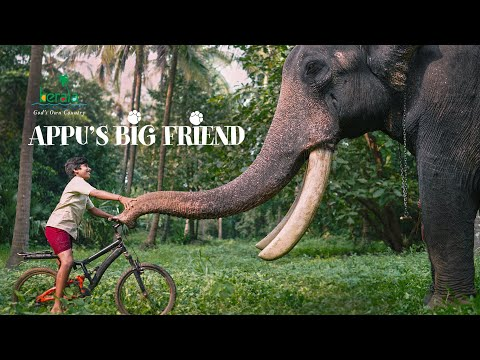

In [14]:
from IPython.display import YouTubeVideo
import rich
rich.print(op)
YouTubeVideo(video_id)
